In [2]:
import torch 
from matplotlib import pyplot as plt 
from tkgdti.train.utils import device_and_data_loading
import argparse 
from tkgdti.data.TriplesDatasetGNN import TriplesDatasetGNN
from tkgdti.data.process_graph import process_graph
import torch_geometric as pyg
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve 
import seaborn as sbn 

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from scipy.stats import rankdata
import os 
from tkgdti.eval.evaluate import evaluate

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def ensemble_predictions(dataset, k=10): 

    fold_test_metrics = []

    pred_ls = []
    for fold in range(k):
        try: 
            uid = [x for x in os.listdir(f'../output/{dataset}/FOLD_{fold}/') if os.path.isdir(f'../output/{dataset}/FOLD_{fold}/{x}')][0]
            preds = pd.read_csv(f'../output/{dataset}/FOLD_{fold}/{uid}/predictions.csv')
            test_metrics = torch.load(f'../output/{dataset}/FOLD_{fold}/{uid}/test_metrics.pt')
            test_metrics['fold'] = fold
            fold_test_metrics.append(test_metrics)
            preds = preds.assign(fold=fold)
            pred_ls.append(preds)
        except: 
            print(f'FOLD {fold} not found')
            continue

    mrr_df = pd.DataFrame(fold_test_metrics)[['fold', 'MRR']]
    mrr_df = mrr_df.assign(weight = [x/sum(mrr_df['MRR']) for x in mrr_df['MRR']])

    preds = pd.concat(pred_ls)[['drug_name', 'prot_name', 'negatives', 'fold', 'prob']].merge(mrr_df[['fold', 'weight']], on='fold')

    # 1. Multiply probability by its fold's weight
    preds['weighted_prob'] = preds['prob'] * preds['weight']

    # 2. Group and sum
    preds_ensemble = (
        preds
        .groupby(['drug_name', 'prot_name', 'negatives'], as_index=False)['weighted_prob']
        .sum()
        .rename(columns={'weighted_prob': 'ensemble_prob'})  # rename if you like
    )

    inchi2name = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')[['inchikey', 'inhibitor']].rename({'inchikey':'drug_name'}, axis=1)
    inchi2name = inchi2name.drop_duplicates()

    preds_ensemble = preds_ensemble.merge(inchi2name, on='drug_name', how='left')

    preds_ensemble = preds_ensemble.sort_values(by='ensemble_prob', ascending=False).reset_index(drop=True)[lambda x: x.negatives]

    ## combine with tge extended 
    tge = pd.read_csv('/home/teddy/local/data/targetome_extended-01-23-25.csv')
    uni2symb = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/omnipath_uniprot2symbol.csv')[['From', 'FirstGene']].rename({'From':'uniprot_id', 'FirstGene':'prot_name'}, axis=1).drop_duplicates()
    tge = tge[['inchi_key', 'uniprot_id', 'assay_value']].drop_duplicates().merge(uni2symb, on='uniprot_id', how='left')[['inchi_key', 'prot_name', 'assay_value']]
    tge = tge.assign(in_targetome_extended=True)
    tge = tge.rename({'inchi_key':'drug_name'}, axis=1)
    tge = tge.groupby(['drug_name', 'prot_name', 'in_targetome_extended'], as_index=False).agg({'assay_value':'mean'})

    preds_ensemble = preds_ensemble.merge(tge, on=['drug_name', 'prot_name'], how='left')
    preds_ensemble.in_targetome_extended.fillna(False, inplace=True)

    return preds_ensemble 


In [4]:
ROOT='../output/from_exacloud/tkge_no_patient/'
print('ensembling GNN predictions...')
gnn_res = ensemble_predictions(f'{ROOT}/GNN/')

print('ensembling COMPLEX2 predictions...')
cpx_res = ensemble_predictions(f'{ROOT}/COMPLEX2/')

ensembling GNN predictions...
FOLD 1 not found
FOLD 2 not found


/tmp/ipykernel_27099/1941299536.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)
/tmp/ipykernel_27099/1941299536.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)


ensembling COMPLEX2 predictions...


/tmp/ipykernel_27099/1941299536.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)
/tmp/ipykernel_27099/1941299536.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)


GNN kd-prob spearmanr: -0.34404515586786205
COMPLEX2 kd-prob spearmanr: -0.3687626719704221


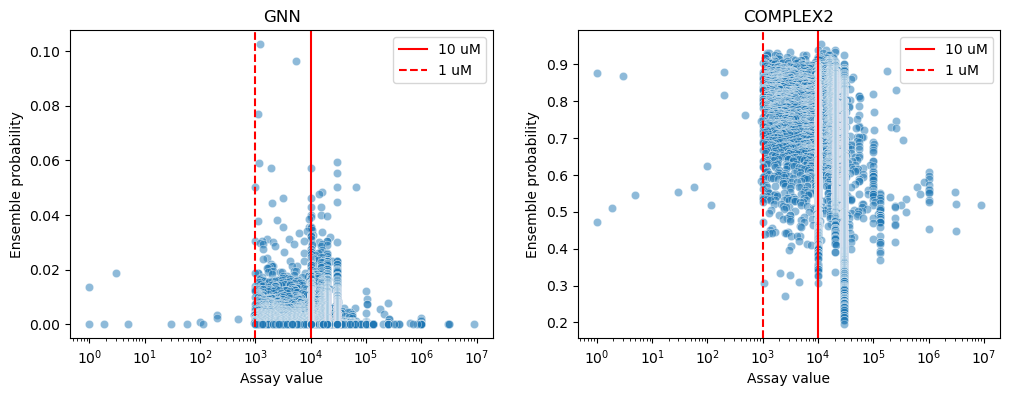

In [5]:
print('GNN kd-prob spearmanr:', gnn_res.assign(assay_log = lambda x: np.log10(x.assay_value))[['ensemble_prob', 'assay_log']].corr(method='spearman').values[0,1])
print('COMPLEX2 kd-prob spearmanr:', cpx_res.assign(assay_log = lambda x: np.log10(x.assay_value))[['ensemble_prob', 'assay_log']].corr(method='spearman').values[0,1])
      
f,axes = plt.subplots(1,2, figsize=(12,4))
sbn.scatterplot(y='ensemble_prob', x='assay_value', data=gnn_res, ax=axes[0], alpha=0.5)
axes[0].set_ylabel('Ensemble probability')
axes[0].set_xlabel('Assay value')  
axes[0].set_title('GNN')
axes[0].set_xscale('log')
axes[0].axvline(10*1e3, color='red', linestyle='-', label='10 uM')
axes[0].axvline(1*1e3, color='red', linestyle='--', label='1 uM')
axes[0].legend()

sbn.scatterplot(y='ensemble_prob', x='assay_value', data=cpx_res, ax=axes[1], alpha=0.5)
axes[1].set_ylabel('Ensemble probability')
axes[1].set_xlabel('Assay value')  
axes[1].set_title('COMPLEX2')
axes[1].set_xscale('log')
axes[1].axvline(10*1e3, color='red', linestyle='-', label='10 uM')
axes[1].axvline(1*1e3, color='red', linestyle='--', label='1 uM')
axes[1].legend()

plt.show()

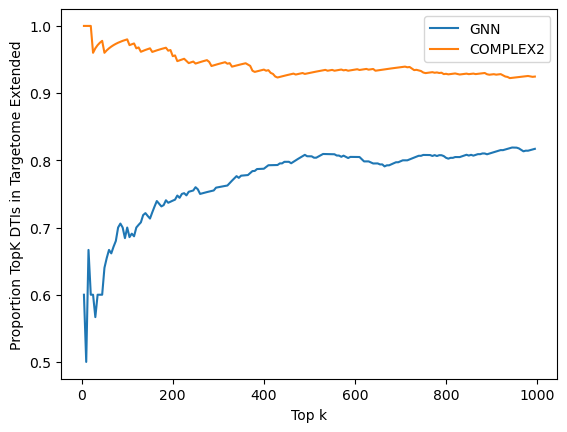

In [6]:
prop_in_targetome_extended1 = []
prop_in_targetome_extended2 = []
topks = np.arange(0,1000,5)
for topk in topks: 
    prop_in_targetome_extended1.append(gnn_res.head(int(topk)).in_targetome_extended.mean())
    prop_in_targetome_extended2.append(cpx_res.head(int(topk)).in_targetome_extended.mean())

plt.figure()
plt.plot(topks, prop_in_targetome_extended1, label='GNN')
plt.plot(topks, prop_in_targetome_extended2, label='COMPLEX2')
plt.xlabel('Top k')
plt.ylabel('Proportion TopK DTIs in Targetome Extended')
plt.legend()
plt.show()

spearmanr [all]: 0.3909139362312152
spearmanr [high prob]: 0.06993006993006994


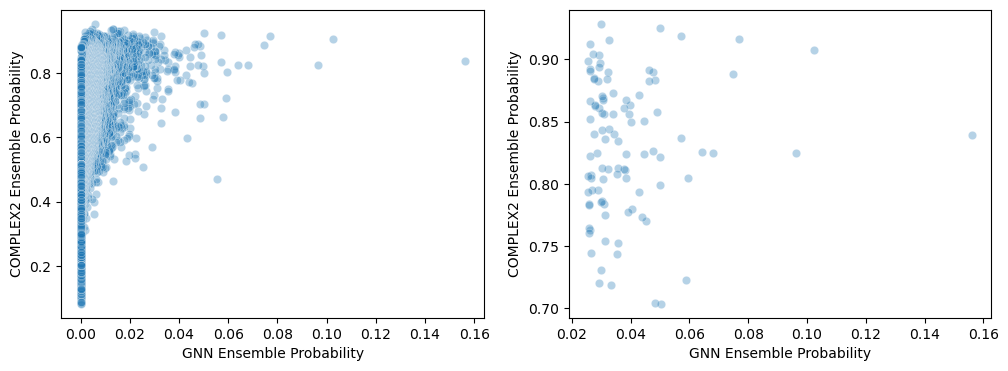

In [7]:
combined = gnn_res.merge(cpx_res, on=['drug_name', 'prot_name'], suffixes=('_gnn', '_cpx'))

print('spearmanr [all]:', combined[['ensemble_prob_gnn', 'ensemble_prob_cpx']].corr(method='spearman').values[0,1])
print('spearmanr [high prob]:', combined[lambda x:( x.ensemble_prob_gnn > 0.05) & ( x.ensemble_prob_cpx > 0.75 )][['ensemble_prob_gnn', 'ensemble_prob_cpx']].corr(method='spearman').values[0,1])

f,axes = plt.subplots(1,2, figsize=(12,4))
sbn.scatterplot(data=combined, x='ensemble_prob_gnn', y='ensemble_prob_cpx', alpha=0.33, ax=axes[0])
axes[0].set_xlabel('GNN Ensemble Probability')
axes[0].set_ylabel('COMPLEX2 Ensemble Probability')

sbn.scatterplot(data=combined[lambda x:( x.ensemble_prob_gnn > 0.025) & ( x.ensemble_prob_cpx > 0.7 )], x='ensemble_prob_gnn', y='ensemble_prob_cpx', alpha=0.33, ax=axes[1])
axes[1].set_xlabel('GNN Ensemble Probability')
axes[1].set_ylabel('COMPLEX2 Ensemble Probability')

plt.show()

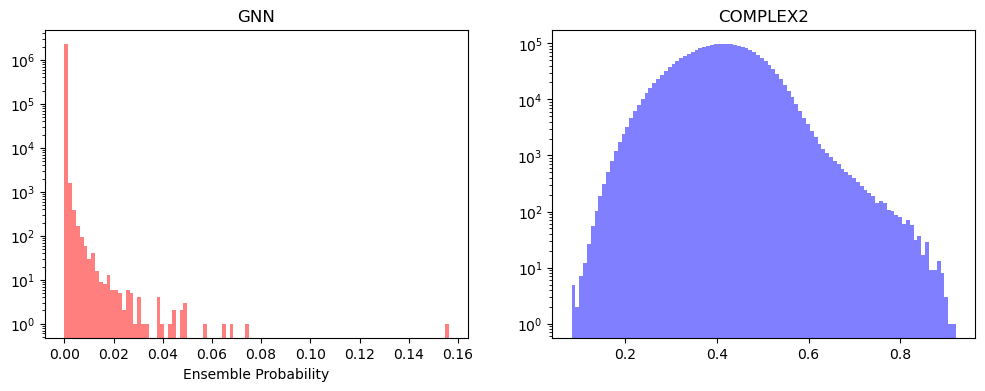

In [8]:
f,axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(gnn_res[lambda x: ~x.in_targetome_extended].ensemble_prob, bins=100, alpha=0.5, label='GNN [-TGE]', color='r')
axes[1].hist(cpx_res[lambda x: ~x.in_targetome_extended].ensemble_prob, bins=100, alpha=0.5, label='COMPLEX2 [-TGE]', color='b')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_title('GNN')
axes[1].set_title('COMPLEX2')
axes[0].set_xlabel('Ensemble Probability')
plt.show() 

In [30]:
FILTER_TO_DRUG = 'Venetoclax'
topk = 100

if FILTER_TO_DRUG is not None: 
    gnn_res2 = gnn_res[lambda x: x.inhibitor == FILTER_TO_DRUG]
    cpx_res2 = cpx_res[lambda x: x.inhibitor == FILTER_TO_DRUG]
else: 
    gnn_res2 = gnn_res
    cpx_res2 = cpx_res

In [39]:

topK_gnn = gnn_res2[lambda x: ~x.in_targetome_extended].head(topk).sort_values(by='ensemble_prob', ascending=False)\
    .reset_index().rename({'index':'global_rank_gnn'}, axis=1)\
    .reset_index().rename({'index':'novel_rank_gnn'}, axis=1).drop_duplicates()

topK_cpx = cpx_res2[lambda x: ~x.in_targetome_extended].head(topk).sort_values(by='ensemble_prob', ascending=False)\
    .reset_index().rename({'index':'global_rank_cpx'}, axis=1)\
    .reset_index().rename({'index':'novel_rank_cpx'}, axis=1).drop_duplicates()

overlapping = topK_gnn.merge(topK_cpx, on=['drug_name', 'prot_name', 'negatives', 'in_targetome_extended', 'assay_value', 'inhibitor'], suffixes=('_gnn', '_cpx'), how='inner')

overlapping = overlapping.assign(avg_rank = (overlapping['novel_rank_gnn'] + overlapping['novel_rank_cpx'])/2)

overlapping = overlapping[['inhibitor', 'prot_name', 'ensemble_prob_gnn', 'ensemble_prob_cpx', 'novel_rank_gnn', 'novel_rank_cpx', 'avg_rank']].sort_values(by='novel_rank_cpx', ascending=True).reset_index(drop=True)

overlapping[['inhibitor', 'prot_name', 'novel_rank_gnn', 'novel_rank_cpx']].head(topk).style.hide()

inhibitor,prot_name,novel_rank_gnn,novel_rank_cpx
Venetoclax,BAX,0,4
Venetoclax,BAK1,1,7
Venetoclax,BBC3,3,8
Venetoclax,BID,23,9
Venetoclax,BCL2L11,6,13
Venetoclax,ERBB2,80,14
Venetoclax,PDGFRA,48,15
Venetoclax,MAP2K5,8,17
Venetoclax,LYN,49,18
Venetoclax,TGFBR2,93,19


In [40]:
# this only applies to venetoclax 
if True: 
    xpr = pd.read_excel('../data/xpr_screen/Ven_vs_DMSO_D14_results.xlsx', sheet_name='gene')
    overlapping = overlapping.merge(xpr[['Gene', 'tiers', 'mid_lfc', 'mid_pval', 'camera_dir', 'camera_qval']].rename({'Gene':'prot_name'}, axis=1), 
                    on='prot_name', how='left').head(topk)
    
overlapping[['mid_pval']].style.hide()

mid_pval
0.000049
0.000006
0.000196
0.000021
0.003776
0.017284
0.138846
0.116280
0.013727
0.000000


spearmanr: -0.011857707509881422


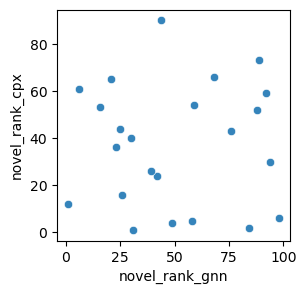

In [13]:
print('spearmanr:', overlapping[['ensemble_prob_gnn', 'ensemble_prob_cpx']].corr(method='spearman').values[0,1]) 

plt.figure(figsize=(3,3))
sbn.scatterplot(data=overlapping, x='novel_rank_gnn', y='novel_rank_cpx', alpha=0.9)
plt.show()

In [14]:
for i, row in overlapping.head(25).iterrows(): 

    print(f'''You are an expert pharmacologist reviewing drug-target interaction (DTI) predictions for novelty and rationality.
Your task is to conduct a comprehensive literature review to determine whether there is supporting or contradicting 
evidence for an interaction between the drug **{row.inhibitor}** and the protein **{row.prot_name}**.

**Instructions:**
1. Search for peer-reviewed studies, patents, clinical trials, and reputable biomedical databases that provide evidence 
for or against this DTI.
2. Summarize key findings, including any experimental data, computational predictions, or known mechanisms of action.
3. Assess the quality, recency, and reliability of the evidence.
4. Provide a structured review with a clear rationale for your conclusion.

**Final Summary:**
End your response with a single concluding paragraph containing one of the following classifications:  
[1] "strong support" - Well-documented interaction with strong experimental/clinical evidence.  
[2] "weak support" - Some supporting evidence, but limited or indirect.  
[3] "strong contradiction" - Strong evidence refuting the interaction.  
[4] "weak contradiction" - Some contradictory findings, but not definitive.  
[5] "limited literature" - Minimal available information on this DTI.  
[6] "inconclusive" - Conflicting or insufficient data to draw a firm conclusion.  

Make your assessment objective, evidence-based, and concise.''')

    
    print() 
    print('-'*50)
    print() 

You are an expert pharmacologist reviewing drug-target interaction (DTI) predictions for novelty and rationality.
Your task is to conduct a comprehensive literature review to determine whether there is supporting or contradicting 
evidence for an interaction between the drug **Ponatinib (AP24534)** and the protein **FLT4**.

**Instructions:**
1. Search for peer-reviewed studies, patents, clinical trials, and reputable biomedical databases that provide evidence 
for or against this DTI.
2. Summarize key findings, including any experimental data, computational predictions, or known mechanisms of action.
3. Assess the quality, recency, and reliability of the evidence.
4. Provide a structured review with a clear rationale for your conclusion.

**Final Summary:**
End your response with a single concluding paragraph containing one of the following classifications:  
[1] "strong support" - Well-documented interaction with strong experimental/clinical evidence.  
[2] "weak support" - Some supp

# Complex^2 top predicted targets (all drugs) with tier 1-3 gene essentiallity

In [47]:
xpr = pd.read_excel('../data/xpr_screen/Ven_vs_DMSO_D14_results.xlsx', sheet_name='gene')
cpx_res2 = cpx_res.merge(xpr[['Gene', 'tiers', 'mid_lfc', 'mid_pval', 'camera_dir', 'camera_qval']].rename({'Gene':'prot_name'}, axis=1),
    on='prot_name', how='left')

cpx_res3 = cpx_res2[lambda x: x.tiers.isin(['Tier1']) & (x.negatives)].sort_values(by='ensemble_prob', ascending=False).head(100)
cpx_res3[['inhibitor', 'prot_name', 'ensemble_prob', 'tiers', 'mid_lfc', 'mid_pval']].head(25).style.hide()

inhibitor,prot_name,ensemble_prob,tiers,mid_lfc,mid_pval
Midostaurin,FGFR3,0.873614,Tier1,2.947925,0.000000
JNJ-28312141,FGFR3,0.873475,Tier1,2.947925,0.000000
AST-487,FGFR3,0.865493,Tier1,2.947925,0.000000
TG101348,IGF1R,0.853866,Tier1,3.746049,0.000000
Crizotinib (PF-2341066),FGFR3,0.852666,Tier1,2.947925,0.000000
JNJ-28312141,IGF1R,0.838502,Tier1,3.746049,0.000000
LY-333531,CDK2,0.835356,Tier1,-2.346907,0.000000
Cabozantinib,FGFR3,0.831618,Tier1,2.947925,0.000000
Sunitinib,IGF1R,0.823101,Tier1,3.746049,0.000000
Sorafenib,FGFR3,0.820276,Tier1,2.947925,0.000000


# Complex^2 top predicted VEN targets with TIER 1-3 gene essentiallity 

In [45]:
xpr = pd.read_excel('../data/xpr_screen/Ven_vs_DMSO_D14_results.xlsx', sheet_name='gene')
cpx_res2 = cpx_res.merge(xpr[['Gene', 'tiers', 'mid_lfc', 'mid_pval', 'camera_dir', 'camera_qval']].rename({'Gene':'prot_name'}, axis=1),
    on='prot_name', how='left')

cpx_res3 = cpx_res2[lambda x: (x.inhibitor == 'Venetoclax') & x.tiers.isin(['Tier1', 'Tier2', 'Tier3']) & (x.negatives)].sort_values(by='ensemble_prob', ascending=False).head(100)
cpx_res3[['inhibitor', 'prot_name', 'ensemble_prob', 'tiers', 'mid_lfc', 'mid_pval']].head(25).style.hide()

inhibitor,prot_name,ensemble_prob,tiers,mid_lfc,mid_pval
Venetoclax,BAK1,0.645328,Tier3,2.094411,0.000006
Venetoclax,MAPK8,0.612865,Tier3,-1.233234,0.000005
Venetoclax,CIT,0.597196,Tier3,-1.274238,0.000010
Venetoclax,AKT1,0.588022,Tier3,-1.917214,0.032839
Venetoclax,PRKAA2,0.566248,Tier3,-1.999959,0.000205
Venetoclax,CASP3,0.566204,Tier3,2.098384,0.000000
Venetoclax,LCK,0.566123,Tier3,1.031062,0.000030
Venetoclax,NTRK3,0.565905,Tier3,1.213929,0.000001
Venetoclax,TP53,0.564897,Tier1,3.877202,0.000000
Venetoclax,NFKB1,0.564737,Tier3,1.664205,0.000000


<Axes: >

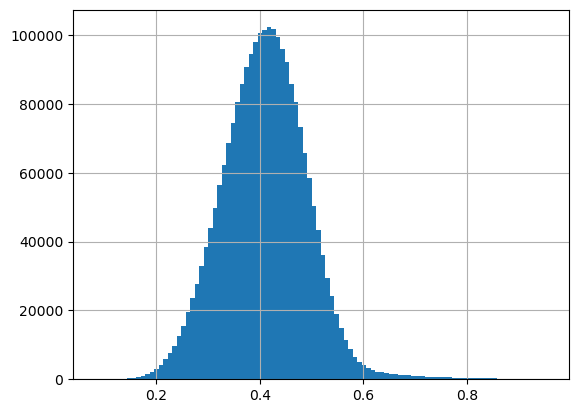

In [41]:
cpx_res.ensemble_prob.hist(bins=100)